In [4]:
import os
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
import numpy as np

from astropy import units as u 
from astropy.table import Table

from snewpy.neutrino import Flavor, MassHierarchy, MixingParameters
from snewpy.models import Nakazato_2013
from snewpy.models.ccsn import Fornax_2022
from snewpy.models.ccsn import Bollig_2016
from snewpy.models.ccsn import Sukhbold_2015
from snewpy.flavor_transformation import AdiabaticMSW, NonAdiabaticMSWH, \
                                         TwoFlavorDecoherence, ThreeFlavorDecoherence, \
                                         NeutrinoDecay, AdiabaticMSWes, NonAdiabaticMSWes
from asteria import set_rcparams
from asteria.simulation import Simulation


%matplotlib inline

C:\Users\sanya\AppData\Local\Temp\ipykernel_16364\404590964.py:13: FutureWarning: snewpy.models.Nakazato_2013 is moved to snewpy.models.ccsn.Nakazato_2013
  from snewpy.models import Nakazato_2013


In [2]:
forn_masses=[9,10,11,12,13,14.01,15,16.99,18.04,19.02,19.99,21,22,23,24,25,26,26.99]

In [3]:
forn_param = list(params for params in Fornax_2022.get_param_combinations() if 
                   params['progenitor_mass'].value in forn_masses)
sukh_param_sfho=list(params for params in Sukhbold_2015.get_param_combinations() if params['eos']=='SFHo')
sukh_param_ls220=list(params for params in Sukhbold_2015.get_param_combinations() if params['eos']=='LS220')

In [4]:
sukh_param_ls220[0]

{'progenitor_mass': <Quantity 27. solMass>, 'eos': 'LS220'}

In [7]:
labels=['nmo','imo']

forn_sims = {
  9: [],
  10: [],
  11: [],
  12: [],
  13: [],
  14.01: [],
  15: [],
  16.99: [],
  18.04: [],
  19.02: [],
  19.99: [],
  21: [],
  22: [],
  23: [],
  24: [],
  25: [],
  26: [],
  26.99: []
}



<Quantity [ 9.  , 10.  , 11.  , 12.  , 12.13, 12.25, 12.5 , 12.7 , 12.85,
           13.  , 13.27, 13.5 , 13.9 , 14.25, 14.44, 15.01, 16.43, 17.07,
           17.5 , 18.05, 19.02, 20.08, 21.  , 22.82, 24.  ] solMass>

In [5]:
sukh_model_sfho_27 = {'name': 'Sukhbold_2015',
            'param': sukh_param_sfho[0]
              }

sukh_model_ls220_27 = {'name': 'Sukhbold_2015',
            'param': sukh_param_ls220[0]
              }

sukh_model_sfho_9 = {'name': 'Sukhbold_2015',
            'param': sukh_param_sfho[1]
              }

sukh_model_ls220_9 = {'name': 'Sukhbold_2015',
            'param': sukh_param_ls220[1]
              }

In [23]:
models=[sukh_model_sfho_27,sukh_model_ls220_27,sukh_model_sfho_9,sukh_model_ls220_9]
labels=['nmo','imo']
hie=['normal','inverted']
for i,mod in enumerate(models):
    for j,lab in enumerate(labels):
        pred = Simulation(model=mod,
                                         distance=10 * u.kpc, 
                                         Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                                         tmin=-10*u.s,  tmax=10*u.s,    dt=1*u.ms,
                                         mixing_scheme='AdiabaticMSW',
                                         hierarchy=hie[j])
        pred.run()
        with open("{}_M={}_eos={}_mix={}.pkl".format(mod['name'], mod['param']['progenitor_mass'].value,
                                                        mod['param']['eos'],
                                                        lab), 'wb') as f:
            pickle.dump(pred, f)

C:\Users\sanya\miniconda3\lib\site-packages\snewpy\models\base.py:302: RuntimeWarning: divide by zero encountered in log
  np.exp(np.log(L) - (2+a)*np.log(Ea) + (1+a)*np.log(1+a)
C:\Users\sanya\miniconda3\lib\site-packages\snewpy\models\base.py:302: RuntimeWarning: invalid value encountered in subtract
  np.exp(np.log(L) - (2+a)*np.log(Ea) + (1+a)*np.log(1+a)
C:\Users\sanya\miniconda3\lib\site-packages\snewpy\models\base.py:303: RuntimeWarning: divide by zero encountered in divide
  - loggamma(1+a) + a*np.log(E) - (1+a)*(E/Ea)) / (u.erg * u.s)


sukhbold-LS220-z9.6.fits:   0%|          | 0.00/619k [00:00<?, ?iB/s]

In [6]:
sukh_sfho_sims = {
    9.6:[],
    27.0:[]
}

sukh_ls220_sims = {
    9.6:[],
    27.0:[]
}
labels=['nmo','imo']
for i,mass in enumerate([9.6,27.0]):
    for j,lab in enumerate(labels):
        with open("Sukhbold_2015_M={}_eos=SFHo_mix={}.pkl".format(mass,
                                                    lab), 'rb') as f:
            sukh_sfho_sims[mass].append(pickle.load(f))
        with open("Sukhbold_2015_M={}_eos=LS220_mix={}.pkl".format(mass,
                                                    lab), 'rb') as f:
            sukh_ls220_sims[mass].append(pickle.load(f)) 

In [7]:
def compute_hits(dist,dt,start,end,sim):
    sim.rebin_result(dt)
    sim.scale_result(dist)
    t, hits = sim.detector_signal(dt)
    id5=np.where(t==start)[0][0]
    id6=np.where(t==end)[0][0]
        
    data=hits[id5:id6]+2000
    return data 

In [17]:
sukh_sfho_sims[mod][0].rebin_result(dt)
sukh_sfho_sims[mod][0].scale_result(10*u.kpc)
t, hits = sukh_sfho_sims[mod][0].detector_signal(dt)
id1=np.where(t==-5*u.s)[0][0]
id2=np.where(t==-.5*u.s)[0][0]
id5=np.where(t==.02*u.s)[0][0]
id6=np.where(t==1*u.s)[0][0]

In [8]:
def compute_hits_with_bg(dist,dt,start,end,sim):
    sim.rebin_result(dt)
    sim.scale_result(dist)
    t, hits = sim.detector_signal(dt)
    bg1 = sim.detector.i3_bg(dt,size=hits.size) + sim.detector.dc_bg(dt,size=hits.size)
    sig=bg1+hits
    id1=np.where(t==-5*u.s)[0][0]
    id2=np.where(t==-.5*u.s)[0][0]
    id5=np.where(t==start)[0][0]
    id6=np.where(t==end)[0][0]

    mean_under=np.mean(sig[id1:id2])-2000
    data_hits=np.subtract(sig,mean_under)[id5:id6]
    return data_hits

In [82]:
hits_sukh_sfho = {
    9.6:[],
    27.0:[]
}

hits_sukh_ls220 = {
    9.6:[],
    27.0:[]
}

dt=20*u.ms
#max_t_dat = t1[np.argmax(norm_data_hits[0])]
for i,mod in enumerate([9.6,27.0]):
    for j in range(2):
        simm_sfho=sukh_sfho_sims[mod][j]
        hits_sukh_sfho[mod].append(compute_hits(12*u.kpc,20*u.ms,.02*u.s,1*u.s,simm_sfho)) 
        
        simm_ls220=sukh_ls220_sims[mod][j]
        hits_sukh_ls220[mod].append(compute_hits(12*u.kpc,20*u.ms,.02*u.s,1*u.s,simm_ls220)) 


In [83]:
sukh_sfho_nh_data = {
    9.6:[],
    27.0:[]
}

sukh_ls220_nh_data = {
    9.6:[],
    27.0:[]
}

sukh_sfho_ih_data = {
    9.6:[],
    27.0:[]
}

sukh_ls220_ih_data = {
    9.6:[],
    27.0:[]
}

dt=20*u.ms

for j,mod in enumerate([9.6,27.0]):
    for i in range(1000):
        data_sim_sfho_nh=sukh_sfho_sims[mod][0]
        data_sim_sfho_ih=sukh_sfho_sims[mod][1]
        sukh_sfho_nh_data[mod].append(compute_hits_with_bg(12*u.kpc,20*u.ms,.02*u.s,1*u.s,data_sim_sfho_nh))
        sukh_sfho_ih_data[mod].append(compute_hits_with_bg(12*u.kpc,20*u.ms,.02*u.s,1*u.s,data_sim_sfho_ih))


        data_sim_ls220_nh=sukh_ls220_sims[mod][0]
        data_sim_ls220_ih=sukh_ls220_sims[mod][1]
        sukh_ls220_nh_data[mod].append(compute_hits_with_bg(12*u.kpc,20*u.ms,.02*u.s,1*u.s,data_sim_ls220_nh))
        sukh_ls220_ih_data[mod].append(compute_hits_with_bg(12*u.kpc,20*u.ms,.02*u.s,1*u.s,data_sim_ls220_ih))

Text(0.5, 1.0, 'Sukhbold SFHo Models, M=9.6, d=10kpc')

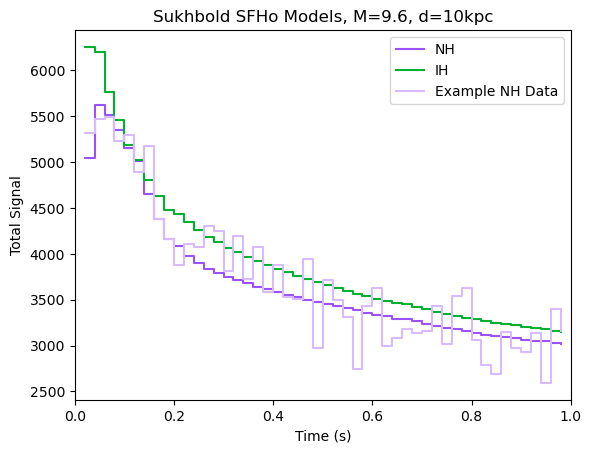

In [99]:
#dt = 10 * u.ms
colors_nmo=['#fc2b1c','#e6e602','#02cf13','#0232cf','#9200b3']
mod_names=['sukh_sfho','sukh_ls220','forn','zha','tamb']


plt.step(t[id5:id6], hits_sukh_sfho[9.6][0], where='post',color='#9b52fa',label=f'NH')
plt.step(t[id5:id6], hits_sukh_sfho[9.6][1], where='post',color='#02b031',label=f'IH')

plt.step(t[id5:id6], sukh_sfho_nh_data[9.6][0], where='post',color='#d7bbfc',label=f'Example NH Data')

    
plt.legend()
plt.xlim(0,1)
plt.xlabel('Time (s)')
plt.ylabel('Total Signal')
plt.title('Sukhbold SFHo Models, M=9.6, d=10kpc')

Text(0.5, 1.0, 'Signal for Sukhbold Models with M=9.6, d=15kpc, 10ms binning')

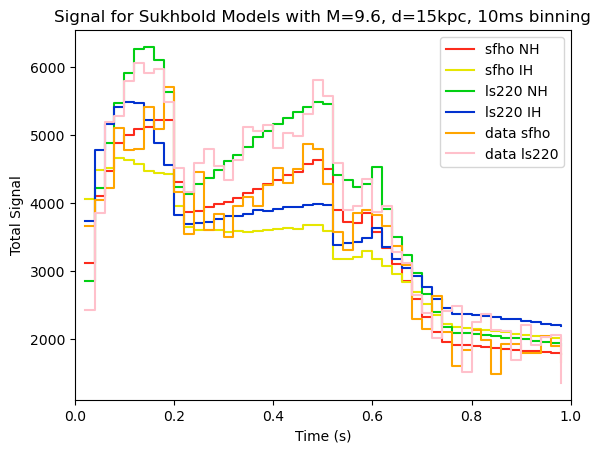

In [255]:
#dt = 10 * u.ms
colors_nmo=['#fc2b1c','#e6e602','#02cf13','#0232cf','#9200b3']
mod_names=['sukh_sfho','sukh_ls220','forn','zha','tamb']


plt.step(t[id5:id6], hits_sukh_sfho[27.0][0], where='post',color=colors_nmo[0],label=f'sfho NH')
plt.step(t[id5:id6], hits_sukh_sfho[27.0][1], where='post',color=colors_nmo[1],label=f'sfho IH')

plt.step(t[id5:id6], hits_sukh_ls220[27.0][0], where='post',color=colors_nmo[2],label=f'ls220 NH')
plt.step(t[id5:id6], hits_sukh_ls220[27.0][1], where='post',color=colors_nmo[3],label=f'ls220 IH')


plt.step(t[id5:id6], sukh_sfho_nh_data[27.0][274], where='post',color='orange',label='data sfho')
plt.step(t[id5:id6], sukh_ls220_nh_data[27.0][274], where='post',color='pink',label='data ls220')

    
plt.legend()
plt.xlim(0,1)
plt.xlabel('Time (s)')
plt.ylabel('Total Signal')
plt.title('Signal for Sukhbold Models with M=9.6, d=15kpc, 10ms binning')

In [19]:
def compute_chi_sq(pred,dat):
    chi_sq=0
    for i in range(len(pred)):
        chi_sq += ((pred[i]-dat[i])**2)/(dat[i])
    return chi_sq

In [87]:
sukh_sfho_chi = {
    9.6:[],
    27.0:[]
}

sukh_ls220_chi = {
    9.6:[],
    27.0:[]
}


for j,mod in enumerate([9.6,27.0]):
    chi_nmo_sfho=[]
    chi_imo_sfho=[]
    chi_nmo_ls220=[]
    chi_imo_ls220=[]
    for i in range(1000):
        chi_nmo_sfho.append(compute_chi_sq(hits_sukh_sfho[mod][0],sukh_sfho_nh_data[mod][i]))
        chi_imo_sfho.append(compute_chi_sq(hits_sukh_sfho[mod][1],sukh_sfho_nh_data[mod][i]))
            
        chi_nmo_ls220.append(compute_chi_sq(hits_sukh_ls220[mod][0],sukh_ls220_nh_data[mod][i]))
        chi_imo_ls220.append(compute_chi_sq(hits_sukh_ls220[mod][1],sukh_ls220_nh_data[mod][i]))
            
    sukh_sfho_chi[mod].append(chi_nmo_sfho)
    sukh_sfho_chi[mod].append(chi_imo_sfho)
        
    sukh_ls220_chi[mod].append(chi_nmo_ls220)
    sukh_ls220_chi[mod].append(chi_imo_ls220)

In [125]:
chi_nmo_sfho=np.array(chi_nmo_sfho)
np.where(chi_nmo_sfho<0)


(array([], dtype=int64),)

$
\chi^{2} = \sum\limits_{i \in \text{bins}} \frac{(N_{i}^{\text{sim}} - N_{i}^{\text{obs}})^2}{N_{i}^{\text{obs}}}
$

$
N_{\chi^{2}}=e^{a\chi^{2}+b}
$

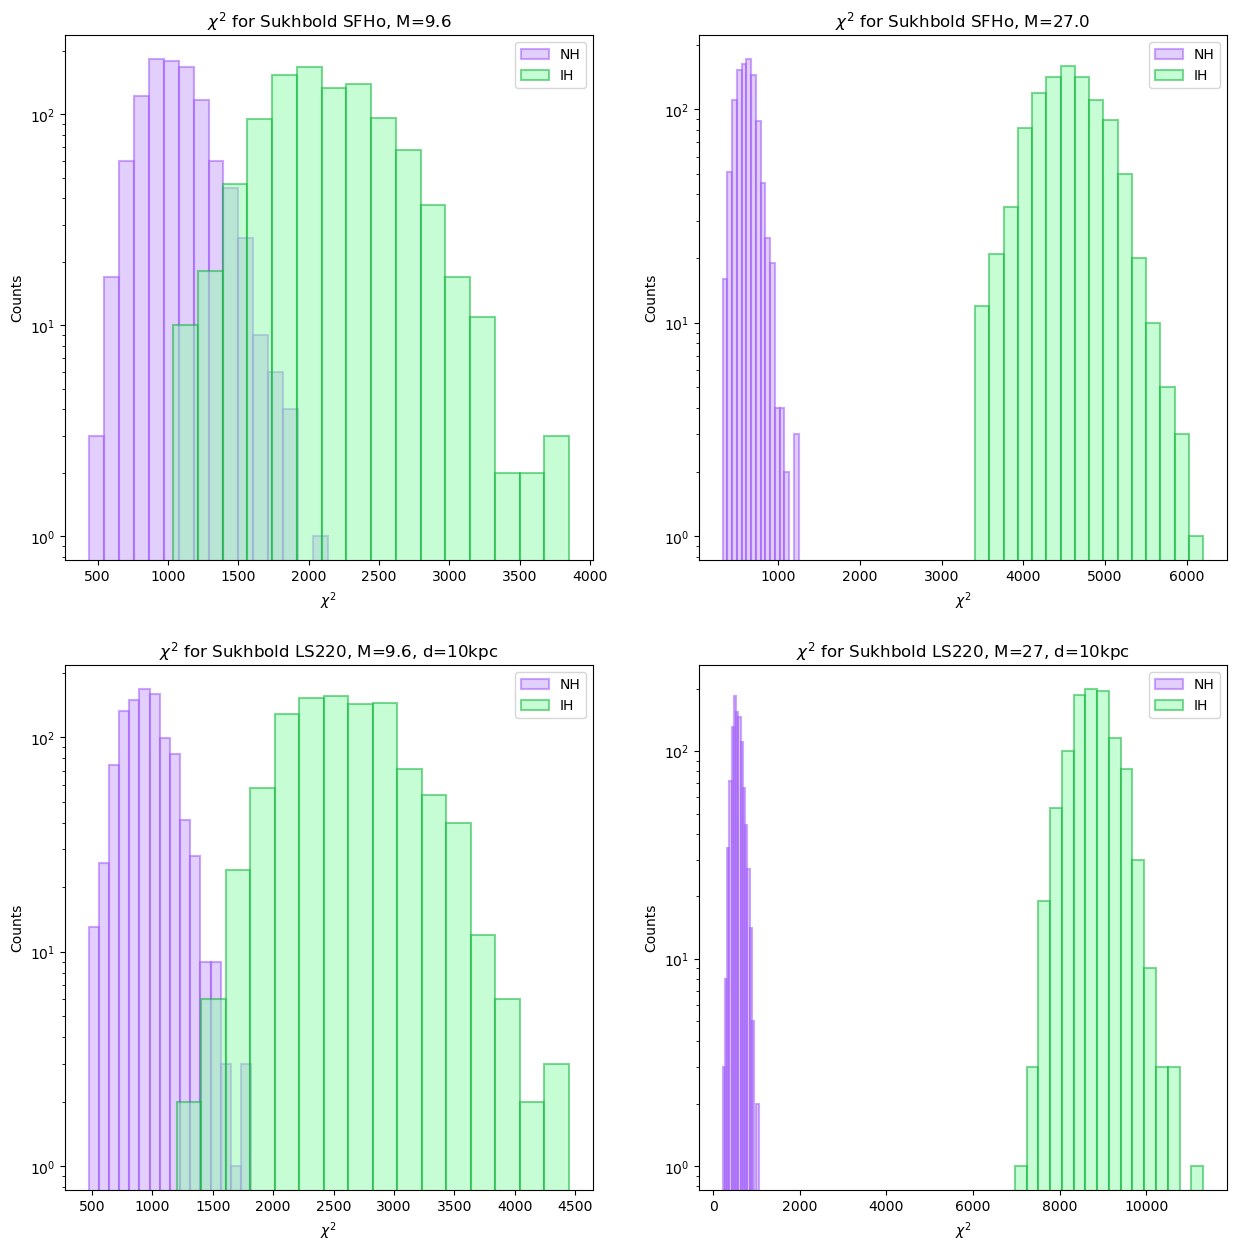

In [95]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()
masses=[9.6,27.0,9.6,27]

for i,ax in enumerate(axes):
    if(i<2):
        ax.hist(sukh_sfho_chi[masses[i]][0], alpha=0.5, color='#c7a0fa', edgecolor='#9b52fa', 
                linewidth=1.5,label='NH',bins=16)
        ax.hist(sukh_sfho_chi[masses[i]][1], alpha=0.5, color='#90fcad', edgecolor='#02b031', 
                linewidth=1.5,label='IH',bins=16)
        ax.legend()
        ax.set_xlabel('$\chi^2$')
        ax.set_ylabel('Counts')
        ax.set_yscale('log')
        ax.set_title('$\chi^2$ for Sukhbold SFHo, M={}'.format(masses[i]))
        
    else:
        ax.hist(sukh_ls220_chi[masses[i]][0], alpha=0.5, color='#c7a0fa', edgecolor='#9b52fa', 
                linewidth=1.5,label='NH', bins=16)
        ax.hist(sukh_ls220_chi[masses[i]][1], alpha=0.5, color='#90fcad', edgecolor='#02b031', 
                linewidth=1.5,label='IH', bins=16)
        ax.legend()
        ax.set_xlabel('$\chi^2$')
        ax.set_ylabel('Counts')
        ax.set_yscale('log')
        ax.set_title('$\chi^2$ for Sukhbold LS220, M={}, d=10kpc'.format(masses[i]))

In [20]:
def compute_p_val(area_tot,start,params,stat,chis_nh,bin_width):
    a,b=params
    upper=-1/a*(500+b)
    lower=stat
    chis_nh=np.array(chis_nh)
    if(lower<start):
        area=len(chis_nh[np.logical_and(chis_nh>stat,chis_nh<start)])*bin_width+1/a*(np.exp(a*upper+b)-np.exp(a*start+b))
    else:
        area=1/a*(np.exp(a*upper+b)-np.exp(a*lower+b))
    area_full=.9*area_tot*bin_width + 1/a*(np.exp(a*upper+b)-np.exp(a*start+b))
    return area/area_full

In [149]:
compute_p_val(1000,bin_edges_nh[split_nh],params_nh,5000)

0.29671296534883956

In [207]:
ha=dist_to_pval_with_plot(sukh_sfho_nh_data[9.6],hits_sukh_sfho[9.6][0],hits_sukh_sfho[9.6][1],24)

3595.186796545875
585361.2828124108
-0.0008646053695057822 6.1065082204030166
23186.5532213103
246283.56580412868


In [208]:
23186/246283

0.09414372896221014

In [263]:
c

In [262]:
ar=[1,2,3,2,1]
print(np.cumsum(ar))
print(.9*9)
np.searchsorted(np.cumsum(ar), .9*9)

[1 3 6 8 9]
8.1


4

In [26]:
def quad_fit(x, a, b):
    return a*x + b

In [21]:
def dist_to_pval_with_plot(data,nh,ih,nbins):
    chis_nh=[]
    chis_ih=[]
    for i, dat in enumerate(data):
        chis_nh.append(compute_chi_sq(nh,dat))
        chis_ih.append(compute_chi_sq(ih,dat))
    
    hist_nh, bin_edges_nh = np.histogram(chis_nh, bins=nbins)
    hist_ih, bin_edges_ih = np.histogram(chis_ih, bins=nbins)
    bin_width_nh = bin_edges_nh[1] - bin_edges_nh[0]
    
    cumulative_nh = np.cumsum(hist_nh)
    split_nh = np.searchsorted(cumulative_nh, .9*len(data))

    tail_region_nh = slice(-(len(hist_nh)-split_nh), None)

    params_nh, cov_nh = curve_fit(quad_fit, bin_edges_nh[tail_region_nh], np.log(hist_nh[tail_region_nh]+1))
    a_nh, b_nh = params_nh
    
    p_vals=[]
    for i,chi_ih in enumerate(chis_ih):
        p=compute_p_val(len(data),bin_edges_nh[split_nh],params_nh,chi_ih,chis_nh,bin_width_nh)
        p_vals.append(p)
        
    x_nh=np.linspace(bin_edges_nh[split_nh],
                     bin_edges_nh[split_nh]+2000,500)
    y_fit_nh = np.exp(a_nh*x_nh+b_nh)
        
    return p_vals,chis_nh,chis_ih,y_fit_nh,x_nh

In [22]:
def dist_to_pval_without_plot(data,nh,ih,nbins):
    chis_nh=[]
    chis_ih=[]
    for i, dat in enumerate(data):
        chis_nh.append(compute_chi_sq(nh,dat))
        chis_ih.append(compute_chi_sq(ih,dat))
    
    hist_nh, bin_edges_nh = np.histogram(chis_nh, bins=nbins)
    hist_ih, bin_edges_ih = np.histogram(chis_ih, bins=nbins)
    bin_width_nh = bin_edges_nh[1] - bin_edges_nh[0]
    
    cumulative_nh = np.cumsum(hist_nh)
    split_nh = np.searchsorted(cumulative_nh, .9*len(data))

    tail_region_nh = slice(-(len(hist_nh)-split_nh), None)

    params_nh, cov_nh = curve_fit(quad_fit, bin_edges_nh[tail_region_nh], np.log(hist_nh[tail_region_nh]+1))
    a_nh, b_nh = params_nh
    
    p_vals=[]
    for i,chi_ih in enumerate(chis_ih):
        p=compute_p_val(len(data),bin_edges_nh[split_nh],params_nh,chi_ih,chis_nh,bin_width_nh)
        p_vals.append(p)
        
    x_nh=np.linspace(bin_edges_nh[split_nh],
                     bin_edges_nh[split_nh]+2000,500)
    y_fit_nh = np.exp(a_nh*x_nh+b_nh)
        
    return p_vals

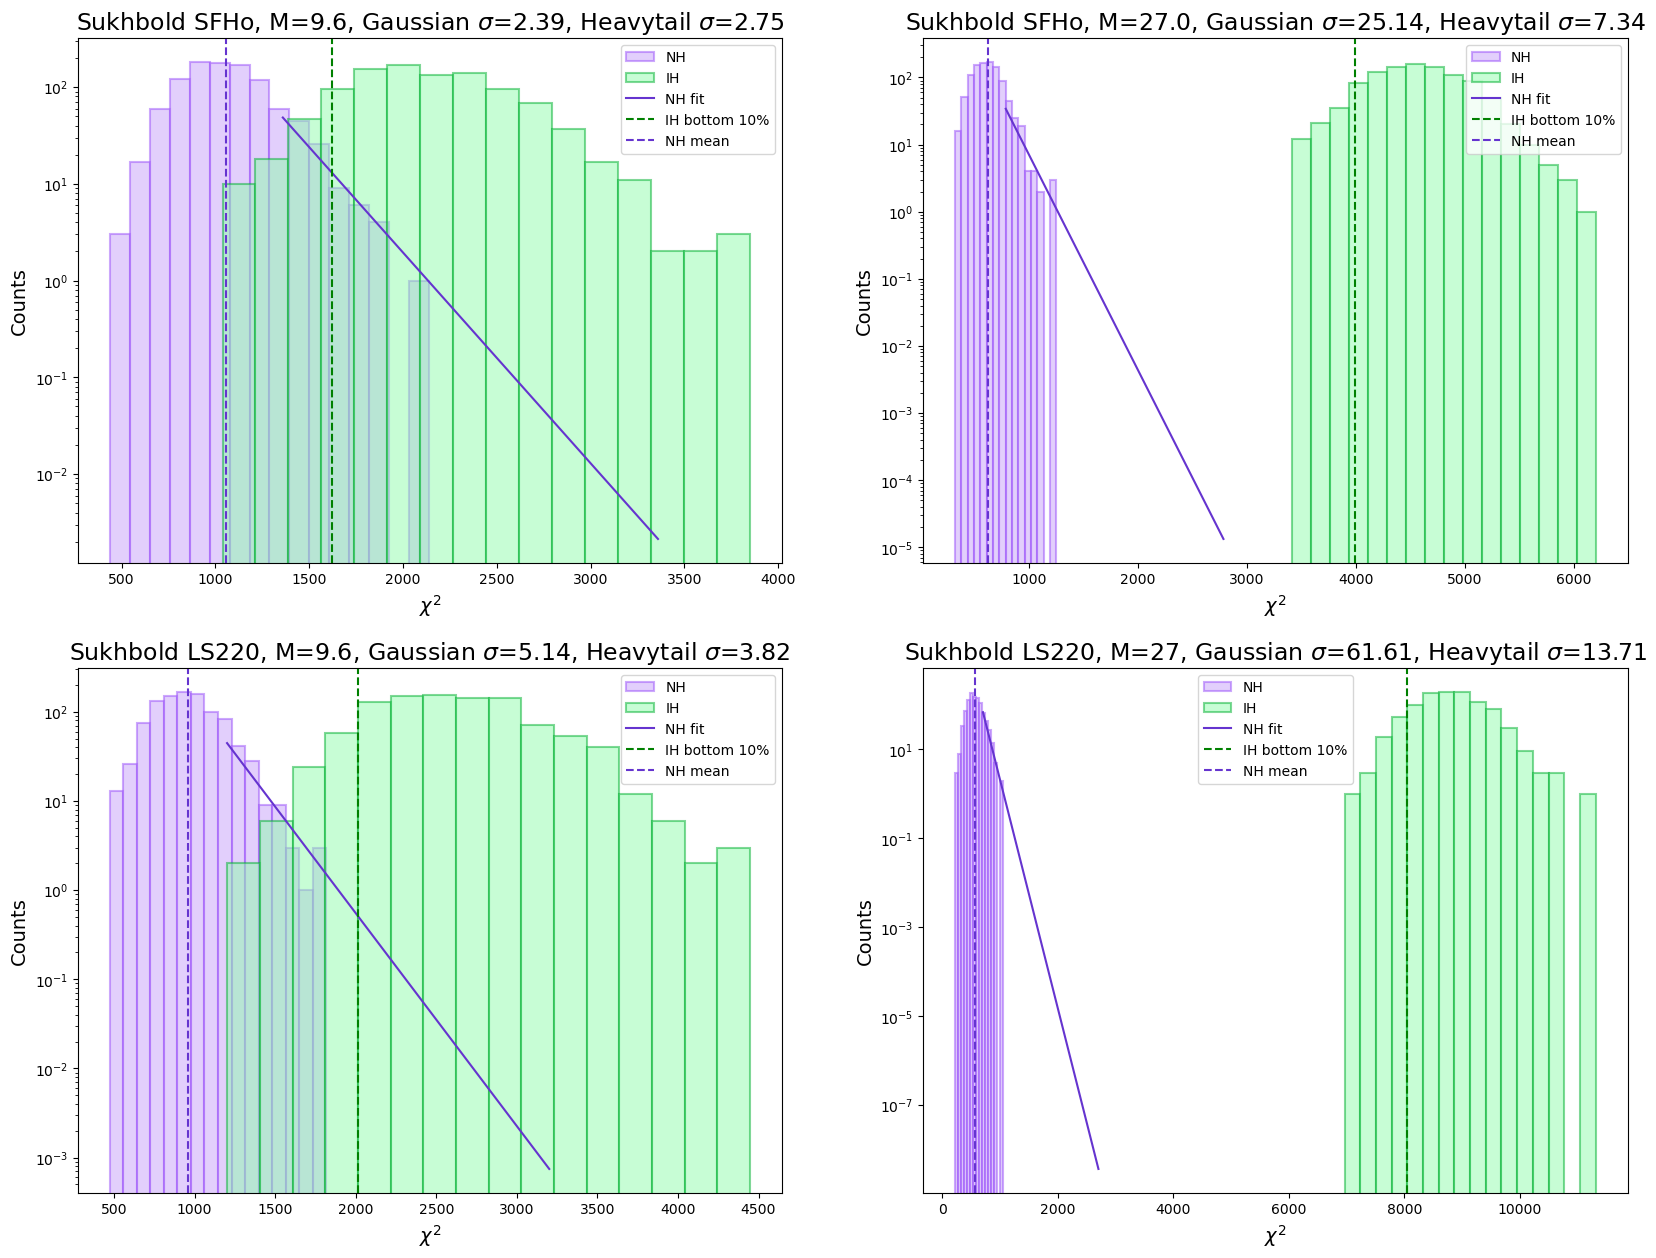

In [102]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()
masses=[9.6,27.0,9.6,27]

for i,ax in enumerate(axes):
    if(i<2):
        m=masses[i]
        p_vals,chi_nh,chi_ih,y_fit_nh,x_nh = dist_to_pval_with_plot(sukh_sfho_nh_data[m],
                                                                      hits_sukh_sfho[m][0],hits_sukh_sfho[m][1],24)
        ax.hist(chi_nh, alpha=0.5, color='#c7a0fa', edgecolor='#9b52fa', 
                linewidth=1.5,label='NH',bins=16)
        ax.hist(chi_ih, alpha=0.5, color='#90fcad', edgecolor='#02b031', 
                linewidth=1.5,label='IH',bins=16)
        ax.plot(x_nh, y_fit_nh, color='#6534cf', label='NH fit')
        
        hist_ih, bin_edges_ih = np.histogram(chi_ih, bins=24)
        cumulative_ih = np.cumsum(hist_ih)
        cutoff_index_ih = np.searchsorted(cumulative_ih, 0.1 * len(sukh_sfho_nh_data[m]))
        cutoff_value_ih = bin_edges_ih[cutoff_index_ih]
        
        ax.axvline(cutoff_value_ih, color='green', linestyle='--', label='IH bottom 10%')
        ax.axvline(np.mean(chi_nh), color='#6534cf', linestyle='--', label='NH mean')

        s=round((cutoff_value_ih-np.mean(chi_nh))/np.std(chi_nh),2)
        
        ax.legend()
        ax.set_yscale('log')
        ax.set_xlabel('$\chi^2$',fontsize=14)
        ax.set_ylabel('Counts',fontsize=14)
        ax.set_title('Sukhbold SFHo, M={}, Gaussian $\sigma$={}, Heavytail $\sigma$={}'.format(masses[i],s,
                                                                                     round(norm.isf(np.median(p_vals)),2)),
                    fontsize=17)
        
    else:
        m=masses[i]
        p_vals,chi_nh,chi_ih,y_fit_nh,x_nh = dist_to_pval_with_plot(sukh_ls220_nh_data[m],
                                                                      hits_sukh_ls220[m][0],hits_sukh_ls220[m][1],24)
        ax.hist(chi_nh, alpha=0.5, color='#c7a0fa', edgecolor='#9b52fa', 
                linewidth=1.5,label='NH',bins=16)
        ax.hist(chi_ih, alpha=0.5, color='#90fcad', edgecolor='#02b031', 
                linewidth=1.5,label='IH',bins=16)
        ax.plot(x_nh, y_fit_nh, color='#6534cf', label='NH fit')
        
        hist_ih, bin_edges_ih = np.histogram(chi_ih, bins=24)
        cumulative_ih = np.cumsum(hist_ih)
        cutoff_index_ih = np.searchsorted(cumulative_ih, 0.1 * len(sukh_ls220_nh_data[m]))
        cutoff_value_ih = bin_edges_ih[cutoff_index_ih]
        
        ax.axvline(cutoff_value_ih, color='green', linestyle='--', label='IH bottom 10%')
        ax.axvline(np.mean(chi_nh), color='#6534cf', linestyle='--', label='NH mean')

        s=round((cutoff_value_ih-np.mean(chi_nh))/np.std(chi_nh),2)
        
        ax.legend()
        ax.set_xlabel('$\chi^2$',fontsize=14)
        ax.set_yscale('log')
        ax.set_ylabel('Counts',fontsize=14)
        ax.set_title('Sukhbold LS220, M={}, Gaussian $\sigma$={}, Heavytail $\sigma$={}'.format(masses[i],s,
                                                                                     round(norm.isf(np.median(p_vals)),2)),
                    fontsize=17)

In [34]:
np.percentile(p_vals, 16)

8.082448665685673e-82

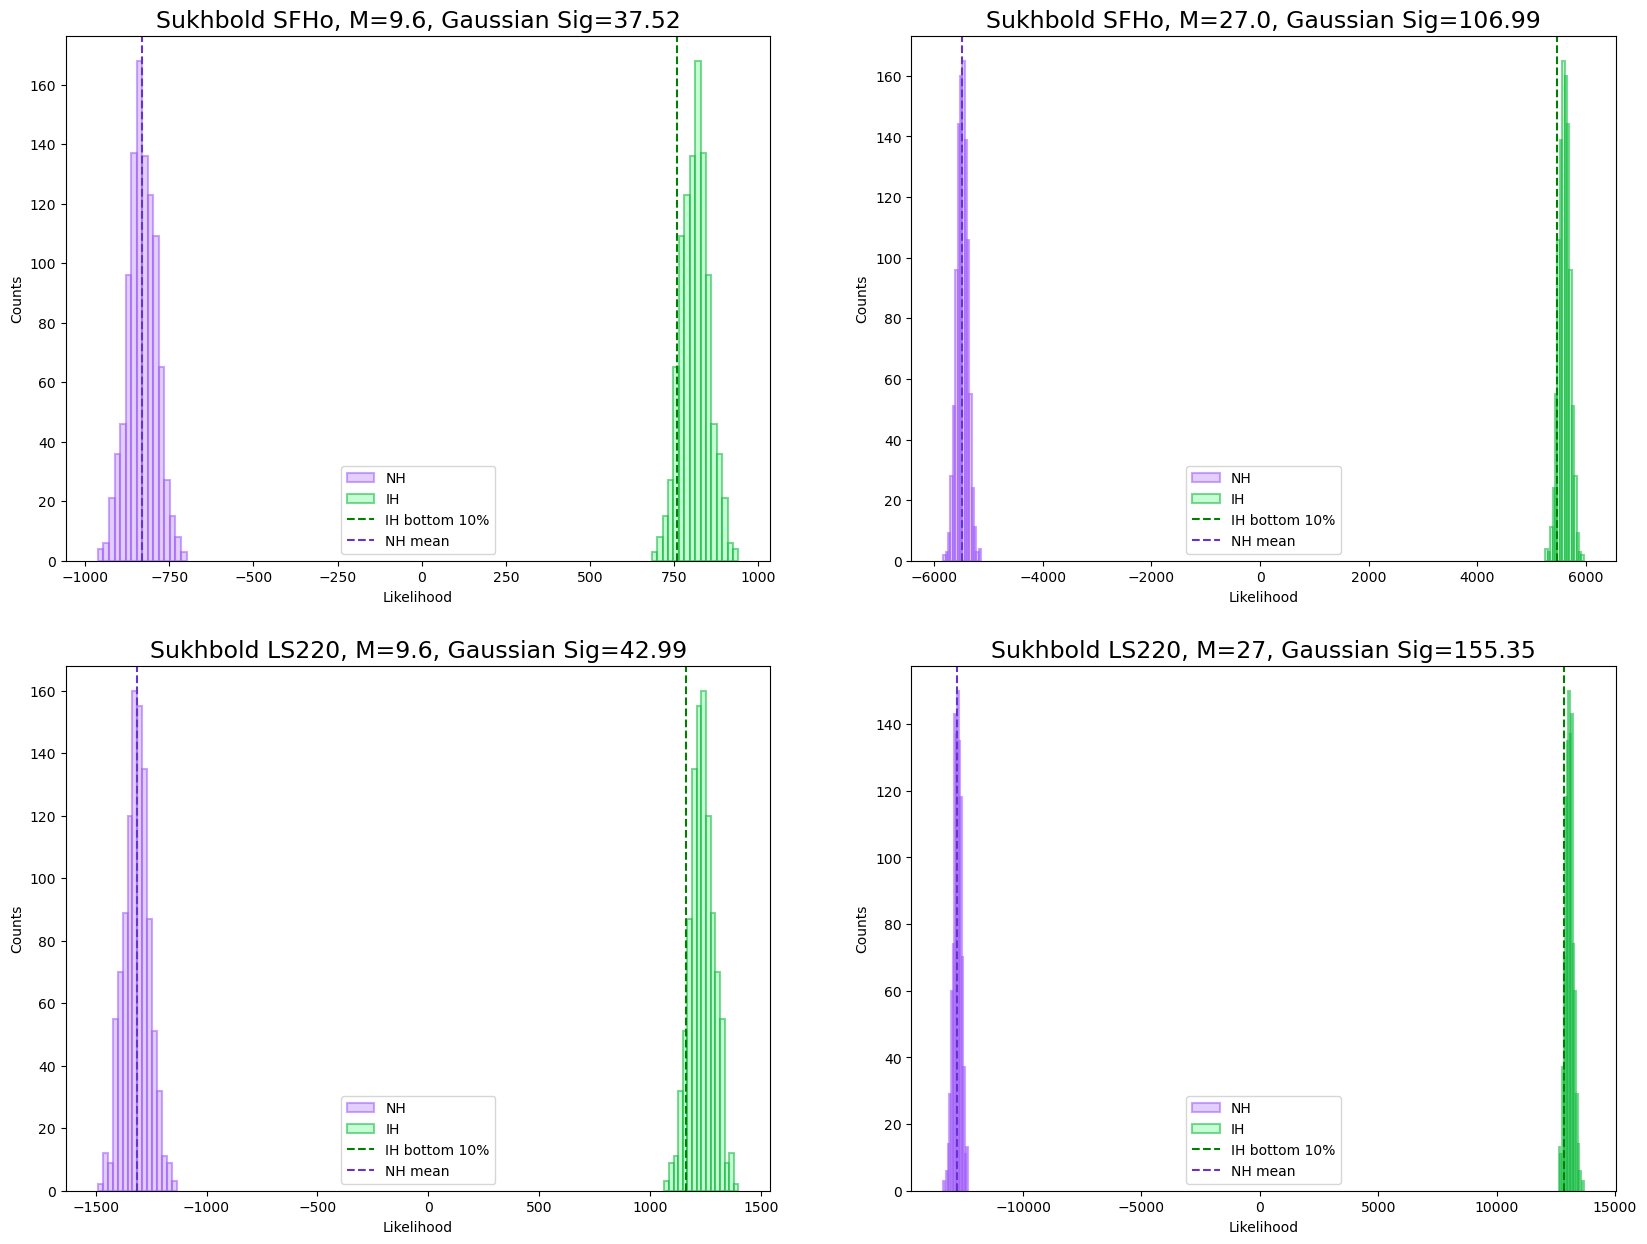

In [342]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()
masses=[9.6,27.0,9.6,27]

for i,ax in enumerate(axes):
    if(i<2):
        m=masses[i]
        log_h, log_i = compute_log_ratio(sukh_sfho_nh_data[m],sukh_sfho_ih_data[m],
                                                    hits_sukh_sfho[m][0],hits_sukh_sfho[m][1])
        ax.hist(log_h, alpha=0.5, color='#c7a0fa', edgecolor='#9b52fa', 
                linewidth=1.5,label='NH',bins=16)
        ax.hist(log_i, alpha=0.5, color='#90fcad', edgecolor='#02b031', 
                linewidth=1.5,label='IH',bins=16)
        
        hist_ih, bin_edges_ih = np.histogram(log_i, bins=24)
        cumulative_ih = np.cumsum(hist_ih)
        cutoff_index_ih = np.searchsorted(cumulative_ih, 0.1 * len(sukh_sfho_ih_data[m]))
        cutoff_value_ih = bin_edges_ih[cutoff_index_ih]
        
        ax.axvline(cutoff_value_ih, color='green', linestyle='--', label='IH bottom 10%')
        ax.axvline(np.mean(log_h), color='#6534cf', linestyle='--', label='NH mean')

        s=round((cutoff_value_ih-np.mean(log_h))/np.std(log_h),2)
        
        ax.legend()
        ax.set_xlabel('Likelihood')
        ax.set_ylabel('Counts')
        ax.set_title('Sukhbold SFHo, M={}, Gaussian Sig={}'.format(masses[i],s,2),fontsize=17)
        
    else:
        m=masses[i]
        log_h, log_i = compute_log_ratio(sukh_ls220_nh_data[m],sukh_ls220_ih_data[m],
                                                    hits_sukh_ls220[m][0],hits_sukh_ls220[m][1])
        ax.hist(log_h, alpha=0.5, color='#c7a0fa', edgecolor='#9b52fa', 
                linewidth=1.5,label='NH',bins=16)
        ax.hist(log_i, alpha=0.5, color='#90fcad', edgecolor='#02b031', 
                linewidth=1.5,label='IH',bins=16)
        
        hist_ih, bin_edges_ih = np.histogram(log_i, bins=24)
        cumulative_ih = np.cumsum(hist_ih)
        cutoff_index_ih = np.searchsorted(cumulative_ih, 0.1 * len(sukh_ls220_ih_data[m]))
        cutoff_value_ih = bin_edges_ih[cutoff_index_ih]
        
        ax.axvline(cutoff_value_ih, color='green', linestyle='--', label='IH bottom 10%')
        ax.axvline(np.mean(log_h), color='#6534cf', linestyle='--', label='NH mean')

        s=round((cutoff_value_ih-np.mean(log_h))/np.std(log_h),2)
        
        ax.legend()
        ax.set_xlabel('Likelihood')
        ax.set_ylabel('Counts')
        ax.set_title('Sukhbold LS220, M={}, Gaussian Sig={}'.format(masses[i],s,2),fontsize=17)

In [340]:
def compute_log_ratio(data_h,data_i,mod_h,mod_i):
    data_h=np.array(data_h)
    data_i=np.array(data_i)
    sig_h=np.std(data_h[:,0])
    sig_i=np.std(data_i[:,0])
    log_h=[]
    log_i=[]
    for j in range(len(data_h)):
        sum_h=0
        sum_i=0
        for i in range(len(data_h[j])):
            mean_h=data_h[j][i]
            mean_i=data_i[j][i]
            sum_h+=(2*mean_i*mod_h[i]-mod_h[i]**2)-(2*mean_i*mod_i[i]-mod_i[i]**2)
            sum_i+=(2*mean_i*mod_i[i]-mod_i[i]**2)-(2*mean_i*mod_h[i]-mod_h[i]**2)
        log_h.append(sum_h/(2*sig_h**2))
        log_i.append(sum_i/(2*sig_i**2))
        

    return log_h, log_i

In [44]:
#sukh_sfho_dist=[]
#sukh_ls220_dist=[]
for dist in range(21,31):
    print(dist)
    sukh_sfho_p = {
        9.6:[],
        27.0:[]
    }

    sukh_ls220_p = {
        9.6:[],
        27.0:[]
    }

    hits_sukh_sfho = {
        9.6:[],
        27.0:[]
    }

    hits_sukh_ls220 = {
        9.6:[],
        27.0:[]
    }

    sukh_sfho_nh_data = {
        9.6:[],
        27.0:[]
    }

    sukh_ls220_nh_data = {
        9.6:[],
        27.0:[]
    }

    for j,mod in enumerate([9.6,27.0]):
        for i in range(10000):
            data_sim_sfho=sukh_sfho_sims[mod][0]
            sukh_sfho_nh_data[mod].append(compute_hits_with_bg(dist*u.kpc,20*u.ms,.02*u.s,1*u.s,data_sim_sfho))


            data_sim_ls220=sukh_ls220_sims[mod][0]
            sukh_ls220_nh_data[mod].append(compute_hits_with_bg(dist*u.kpc,20*u.ms,.02*u.s,1*u.s,data_sim_ls220))


        for i in range(2):
            simm_sfho=sukh_sfho_sims[mod][i]
            hits_sukh_sfho[mod].append(compute_hits(dist*u.kpc,20*u.ms,.02*u.s,1*u.s,simm_sfho)) 

            simm_ls220=sukh_ls220_sims[mod][i]
            hits_sukh_ls220[mod].append(compute_hits(dist*u.kpc,20*u.ms,.02*u.s,1*u.s,simm_ls220)) 



        p_vals_sfho=dist_to_pval_without_plot(sukh_sfho_nh_data[mod],
                                                                hits_sukh_sfho[mod][0],hits_sukh_sfho[mod][1],24)

        sukh_sfho_p[mod].append(norm.isf(np.median(p_vals_sfho)))
        sukh_sfho_p[mod].append(norm.isf(np.percentile(p_vals_sfho, 16)))
        sukh_sfho_p[mod].append(norm.isf(np.percentile(p_vals_sfho, 84)))

        p_vals_ls220=dist_to_pval_without_plot(sukh_ls220_nh_data[mod],
                                                                hits_sukh_ls220[mod][0],hits_sukh_ls220[mod][1],24)
        sukh_ls220_p[mod].append(norm.isf(np.median(p_vals_ls220)))
        sukh_ls220_p[mod].append(norm.isf(np.percentile(p_vals_ls220, 16)))
        sukh_ls220_p[mod].append(norm.isf(np.percentile(p_vals_ls220, 84)))

    sukh_sfho_dist.append(sukh_sfho_p)
    sukh_ls220_dist.append(sukh_ls220_p)

21
22
23
24
25
26
27
28
29
30


In [40]:
sukh_sfho_log=[]
sukh_ls220_log=[]
for dist in range(1,21):
    print(dist)
    sukh_sfho_ih_data = {
        9.6:[],
        27.0:[]
    }

    sukh_ls220_ih_data = {
        9.6:[],
        27.0:[]
    }

    hits_sukh_sfho = {
        9.6:[],
        27.0:[]
    }

    hits_sukh_ls220 = {
        9.6:[],
        27.0:[]
    }

    sukh_sfho_nh_data = {
        9.6:[],
        27.0:[]
    }

    sukh_ls220_nh_data = {
        9.6:[],
        27.0:[]
    }

    for j,mod in enumerate([9.6,27.0]):
        for i in range(10000):
            data_sim_sfho_nh=sukh_sfho_sims[mod][0]
            data_sim_sfho_ih=sukh_sfho_sims[mod][1]
            sukh_sfho_nh_data[mod].append(compute_hits_with_bg(dist*u.kpc,20*u.ms,.02*u.s,1*u.s,data_sim_sfho_nh))
            sukh_sfho_ih_data[mod].append(compute_hits_with_bg(dist*u.kpc,20*u.ms,.02*u.s,1*u.s,data_sim_sfho_ih))


            data_sim_ls220_nh=sukh_ls220_sims[mod][0]
            data_sim_ls220_ih=sukh_ls220_sims[mod][1]
            sukh_ls220_nh_data[mod].append(compute_hits_with_bg(dist*u.kpc,20*u.ms,.02*u.s,1*u.s,data_sim_ls220_nh))
            sukh_ls220_ih_data[mod].append(compute_hits_with_bg(dist*u.kpc,20*u.ms,.02*u.s,1*u.s,data_sim_ls220_ih))


        for i in range(2):
            simm_sfho=sukh_sfho_sims[mod][i]
            hits_sukh_sfho[mod].append(compute_hits(dist*u.kpc,20*u.ms,.02*u.s,1*u.s,simm_sfho)) 

            simm_ls220=sukh_ls220_sims[mod][i]
            hits_sukh_ls220[mod].append(compute_hits(dist*u.kpc,20*u.ms,.02*u.s,1*u.s,simm_ls220)) 



        p_vals_sfho=dist_to_pval_without_plot(sukh_sfho_nh_data[mod],
                                                                hits_sukh_sfho[mod][0],hits_sukh_sfho[mod][1],24)
        sukh_sfho_p[mod].append(norm.isf(np.median(p_vals_sfho)))
        sukh_sfho_p[mod].append(norm.isf(np.std(p_vals_sfho)))

        p_vals_ls220=dist_to_pval_without_plot(sukh_ls220_nh_data[mod],
                                                                hits_sukh_ls220[mod][0],hits_sukh_ls220[mod][1],24)
        sukh_ls220_p[mod].append(norm.isf(np.median(p_vals_ls220)))
        sukh_ls220_p[mod].append(norm.isf(np.std(p_vals_ls220)))

    sukh_sfho_dist.append(sukh_sfho_p)
    sukh_ls220_dist.append(sukh_ls220_p)

np.std(np.array(sukh_ls220_nh_data[9.6])[:,0])

1
2


KeyboardInterrupt: 

(7.5, 30.0)

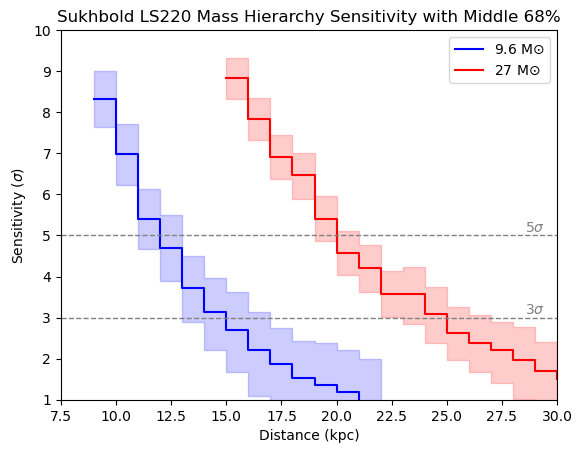

In [103]:
prec_9_16=[]
prec_9_84=[]
sigs_9=[]
dist_9=[]

prec_27_16=[]
prec_27_84=[]
sigs_27=[]
dist_27=[]
for i,dist in enumerate(sukh_ls220_dist):
    if(dist[9.6][0]<10 and dist[9.6][0]>=.8):
        sigs_9.append(dist[9.6][0])
        dist_9.append(i+1)
        prec_9_16.append(dist[9.6][1])
        prec_9_84.append(dist[9.6][2])
    elif(dist[9.6][0]<.8):
        break
    
for i,dist in enumerate(sukh_ls220_dist):
    if(dist[27.0][0]<10 and dist[27.0][0]>=.8):
        sigs_27.append(dist[27.0][0])
        dist_27.append(i+1)
        prec_27_16.append(dist[27.0][1])
        prec_27_84.append(dist[27.0][2])
    elif(dist[27.0][0]<.8):
        break

plt.step(dist_9,sigs_9,color='blue',where='post',label='9.6 M$\odot$')
plt.fill_between(dist_9, prec_9_16, prec_9_84,step='post',color='blue', alpha=0.2)

plt.step(dist_27,sigs_27,color='red',where='post',label='27 M$\odot$')
plt.fill_between(dist_27, prec_27_16, prec_27_84,step='post',color='red', alpha=0.2)

plt.axhline(y=3, color='grey', linestyle='--', linewidth=1)
plt.axhline(y=5, color='grey', linestyle='--', linewidth=1)
plt.text(29, 5.1, '5$\sigma$', color='grey', ha='center')
plt.text(29, 3.1, '3$\sigma$', color='grey', ha='center')

plt.legend()
plt.title('Sukhbold LS220 Mass Hierarchy Sensitivity with Middle 68%')
plt.ylabel('Sensitivity ($\sigma$)')
plt.xlabel('Distance (kpc)')
plt.ylim(1,10)
plt.xlim(7.5,30)


(7.5, 30.0)

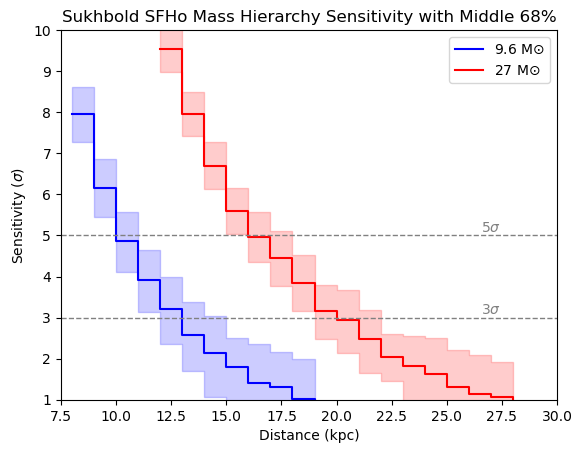

In [104]:
prec_9_16=[]
prec_9_84=[]
sigs_9=[]
dist_9=[]

prec_27_16=[]
prec_27_84=[]
sigs_27=[]
dist_27=[]
for i,dist in enumerate(sukh_sfho_dist):
    if(dist[9.6][0]<10 and dist[9.6][0]>.8):
        sigs_9.append(dist[9.6][0])
        dist_9.append(i+1)
        prec_9_16.append(dist[9.6][1])
        prec_9_84.append(dist[9.6][2])
    elif(dist[9.6][0]<.8):
        break
    
for i,dist in enumerate(sukh_sfho_dist):
    if(dist[27.0][0]<10 and dist[27.0][0]>.8):
        sigs_27.append(dist[27.0][0])
        dist_27.append(i+1)
        prec_27_16.append(dist[27.0][1])
        prec_27_84.append(dist[27.0][2])
    elif(dist[27.0][0]<.8):
        break

plt.step(dist_9,sigs_9,color='blue',where='post',label='9.6 M$\odot$')
plt.fill_between(dist_9, prec_9_16, prec_9_84,step='post',color='blue', alpha=0.2)

plt.step(dist_27,sigs_27,color='red',where='post',label='27 M$\odot$')
plt.fill_between(dist_27, prec_27_16, prec_27_84,step='post',color='red', alpha=0.2)

plt.axhline(y=3, color='grey', linestyle='--', linewidth=1)
plt.axhline(y=5, color='grey', linestyle='--', linewidth=1)
plt.text(27, 5.1, '5$\sigma$', color='grey', ha='center')
plt.text(27, 3.1, '3$\sigma$', color='grey', ha='center')

plt.legend()
plt.title('Sukhbold SFHo Mass Hierarchy Sensitivity with Middle 68%')
plt.ylabel('Sensitivity ($\sigma$)')
plt.xlabel('Distance (kpc)')
plt.ylim(1,10)
plt.xlim(7.5,30)


In [111]:
np.exp(-15)

3.059023205018258e-07

In [5]:
sens=np.load('sensitivity_sukh_theta12.npz',allow_pickle=True)['arr_0']

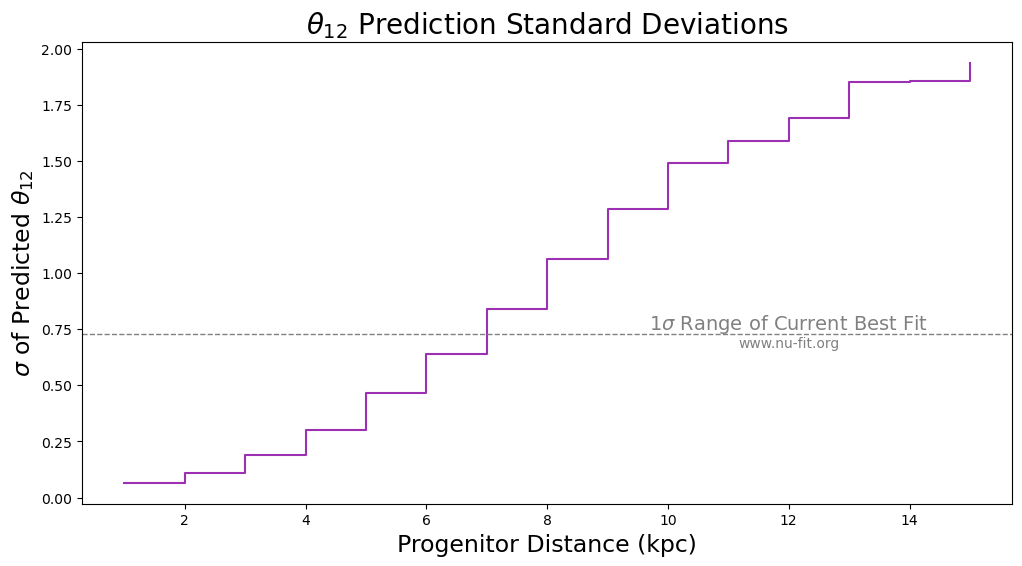

In [11]:
dists=np.linspace(1,15,15)
plt.figure(figsize=(12, 6))
plt.step(dists,sens,color='#9b30b3',where='post')

plt.axhline(y=.73, color='grey', linestyle='--', linewidth=1)
plt.text(12, .73+.02, '1$\sigma$ Range of Current Best Fit', color='grey', ha='center',fontsize=14)
plt.text(12, .73-.06, 'www.nu-fit.org', color='grey', ha='center')

plt.title(r'$\theta_{12}$ Prediction Standard Deviations',fontsize=20)
plt.ylabel(r'$\sigma$ of Predicted $\theta_{12}$',fontsize=17)
plt.xlabel('Progenitor Distance (kpc)',fontsize=17)
plt.savefig('sigs_t12.png', dpi=300, bbox_inches='tight')

# Trick to Convert a p-value to Gaussian Sigma

This uses the "survival function" of the Guassian PDF to convert arbitrary p-values to equivalent multiples of the sigma of a normal distribution.

In [20]:
from scipy.stats import norm

In [166]:
#- Survival function: convert sigma to tail probability (p-value)
norm.sf(-.14)

0.5556700048059064

In [168]:
#- Inverse survival function: convert tail probability to sigma
norm.isf(.6)

-0.2533471031357997

In [53]:
norm.isf(1e-300)

37.0470962993612